# 引言

## 研究目的

### 参考国泰君安证券研报《20181128-基于CCK模型的股票市场羊群效应研究》，对市场上存在的个别股票的涨跌引起相关股票收益率联动的现象进行分析探究。根据研报构建CCK模型，并进行改良，寻找更多联动信号，并正确分析市场趋势。

## 研究思路

### 1.根据研究报告，计算市场回报率并进行改良
### 2.在CCK模型的基础上，增加过滤指标进行分析和改良
### 3.通过改良后，并在此基础上进行回测分析。

## 研究结论

### 1.在本文进行改良后，模型信号出现的次数更多，但是纯度下降了。
### 2.不管标的指数是宽基还是行业，做多策略都明显优于做空策略，但是策略的收益率不是很出众。
### 3.与研报相同的是，策略有效性和标的指数的市值风格和风格纯度有关，市值越高出效果越好。
### 4.通过回测判断，板块间确实存在羊群效应，而且CCK模型也能很好分析出羊群效应出现的时间点，但是不足的是在区分市场方向上并不是很好，甚至会出现错误区分市场方向导致大额亏损的状况
### 5.最后，羊群效应确实如研报所言，确实存在，不过本文认为羊群效应不管多空都发生在短期，且人为区分信号所反映的市场方向更好


本文中所涉及的A股综合日市场回报率指标资料源自国泰安数据库，以下是国泰安数据库(CSMAR)的网址

http://www.gtarsc.com/Login/index?ReturnUrl=%2fHome%2fIndex  

下文代码中涉及国泰安数据的都会用CSMAR进行前缀标记

（下文中提到的CSMAR的市场回报率全称为）
     
    （——考虑现金红利再投资的A股综合日市场回报率（流通市值加权平均法））

In [207]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/22418
# 标题：精英任务获奖作品——作者：Eden666

from jqdata import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import time
import statsmodels.api as sm 
from sklearn.preprocessing import scale
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [208]:
#展示CSMAR的A股综合日市场回报率表格
TRD = pd.read_excel('TRD20090101-20101231.xlsx')
CSMAR_market = TRD[TRD['综合市场类型']==5]
CSMAR_market.index= CSMAR_market.datetime
del CSMAR_market['Market_return_rate.1']
CSMAR_market_sample = CSMAR_market[(CSMAR_market.datetime>'2010-10-12'
                                   )&(CSMAR_market.datetime<='2010-11-06')
                                  ].sort_values('datetime',ascending=True)
print('国泰安数据库提供的考虑现金红利再投资的A股综合日市场回报率（流通市值加权平均法）')
print('')
display(CSMAR_market_sample.tail())

国泰安数据库提供的考虑现金红利再投资的A股综合日市场回报率（流通市值加权平均法）



,综合市场类型,datetime,Market_return_rate,计算的有效公司数量
datetime,,,,
2010-11-01,5,2010-11-01,0.027377,1758
2010-11-02,5,2010-11-02,-0.004603,1766
2010-11-03,5,2010-11-03,-0.009351,1765
2010-11-04,5,2010-11-04,0.018933,1770
2010-11-05,5,2010-11-05,0.014268,1759


    国泰安的数据库仅能免费提供2009年1月1日到2010年12月31日综合日市场回报率的数据，在文章仅在刚开始引用国泰安库的A股综合日市场的市场回报率。如果要购买所有年份的数据的话至少要543元才能获得，基于本文作者穷苦生活现状分析，购买这一指标并不现实所有改为由自己构建指标进行回测。



医药生物行业在10年10月13到11月06这段时间内每股每日的收盘价


,000004.XSHE,000028.XSHE,000078.XSHE,000153.XSHE,000403.XSHE,000423.XSHE,000513.XSHE,000522.XSHE,000538.XSHE,000545.XSHE,000566.XSHE,000590.XSHE,000591.XSHE,000597.XSHE,000603.XSHE,000605.XSHE,000607.XSHE,000627.XSHE,000650.XSHE,000661.XSHE,000669.XSHE,000705.XSHE,000739.XSHE,000756.XSHE,000766.XSHE,000788.XSHE,000790.XSHE,000919.XSHE,000952.XSHE,000963.XSHE,000989.XSHE,000990.XSHE,000999.XSHE,002001.XSHE,002004.XSHE,002007.XSHE,002019.XSHE,002020.XSHE,002022.XSHE,002030.XSHE,...,600466.XSHG,600479.XSHG,600488.XSHG,600511.XSHG,600513.XSHG,600518.XSHG,600521.XSHG,600529.XSHG,600530.XSHG,600535.XSHG,600538.XSHG,600556.XSHG,600557.XSHG,600568.XSHG,600572.XSHG,600587.XSHG,600594.XSHG,600613.XSHG,600645.XSHG,600664.XSHG,600666.XSHG,600671.XSHG,600706.XSHG,600713.XSHG,600750.XSHG,600763.XSHG,600771.XSHG,600781.XSHG,600789.XSHG,600796.XSHG,600803.XSHG,600812.XSHG,600829.XSHG,600833.XSHG,600866.XSHG,600867.XSHG,600976.XSHG,600993.XSHG,600998.XSHG,601607.XSHG
2010-11-01,11.95,33.33,5.58,8.84,3.16,40.22,12.46,18.91,39.70,3.75,5.05,9.70,3.63,17.67,22.00,9.62,8.22,6.46,6.85,51.19,15.04,5.93,3.19,6.19,8.15,11.55,7.26,9.84,12.45,6.84,10.18,12.68,22.36,9.44,6.75,20.69,5.90,3.51,15.53,5.32,...,2.49,11.74,5.39,22.70,10.92,7.80,7.20,9.19,3.86,11.35,5.59,4.14,12.17,2.13,3.08,10.18,8.72,10.92,9.10,11.39,5.02,13.37,9.57,6.63,18.49,9.46,5.34,15.01,7.73,8.42,11.17,13.05,14.12,8.77,13.81,4.15,19.40,14.67,NaN,19.15
2010-11-02,11.96,33.09,5.60,8.73,3.16,39.58,12.54,18.40,39.05,3.67,5.31,10.61,3.71,17.42,22.00,9.50,8.32,6.28,6.74,49.00,14.97,5.91,3.15,6.11,8.07,11.46,7.41,9.87,12.20,6.96,10.20,12.33,22.38,9.10,6.57,20.35,5.83,3.41,15.22,5.29,...,2.51,11.53,5.59,22.52,10.54,7.73,7.03,9.02,3.81,11.43,5.69,4.14,12.17,2.11,2.99,10.20,8.69,10.99,9.09,11.24,4.92,13.23,9.57,6.45,18.35,9.16,5.34,14.90,7.61,8.25,11.54,13.45,13.71,8.62,14.43,4.25,18.94,14.84,18.44,19.13
2010-11-03,12.09,33.87,5.40,8.86,3.16,39.74,12.37,17.77,39.20,3.59,5.66,10.48,3.68,17.08,22.00,9.59,8.27,6.09,7.05,52.28,14.58,5.90,3.10,6.14,8.09,11.81,7.42,10.08,12.22,7.15,10.29,12.70,22.46,8.78,6.47,20.11,5.78,3.38,14.96,5.11,...,2.47,11.51,5.60,22.18,9.88,8.03,7.12,8.93,3.87,11.55,5.84,4.14,11.42,2.09,2.95,9.92,8.64,10.99,9.55,11.01,4.89,13.43,9.57,6.68,17.92,9.28,5.34,15.23,7.44,8.09,11.57,13.14,14.01,8.94,14.02,4.23,18.45,14.46,17.00,19.31
2010-11-04,12.69,34.48,5.48,9.23,3.16,41.46,12.61,18.76,40.39,3.62,5.69,10.61,3.95,17.22,23.11,9.64,8.43,6.24,7.43,52.92,14.49,5.93,3.15,6.25,8.22,11.57,7.37,10.14,12.36,7.48,10.43,12.71,22.77,8.96,6.62,20.35,5.84,3.43,15.38,5.19,...,2.49,11.59,5.64,22.34,9.95,8.06,7.10,9.03,3.97,11.65,5.80,4.14,11.73,2.13,3.07,10.15,8.61,11.07,9.70,11.11,5.05,13.59,9.57,6.86,19.52,9.43,5.34,15.95,7.54,8.28,11.69,13.24,14.29,9.33,14.36,4.38,19.36,15.08,18.70,19.77
2010-11-05,12.68,35.22,5.57,9.63,3.16,41.31,13.15,19.72,39.84,3.72,5.76,10.84,3.87,17.35,24.26,9.69,8.43,6.40,7.48,53.13,14.81,6.11,3.23,6.30,8.45,11.41,7.52,10.10,12.55,7.58,10.44,13.07,22.73,9.08,6.52,20.49,5.97,3.49,15.61,5.29,...,2.54,11.74,5.86,22.13,10.07,7.95,7.13,9.02,3.98,11.86,5.82,4.14,11.95,2.14,3.06,10.52,8.74,11.24,9.59,11.08,5.08,14.39,9.57,6.71,20.11,9.52,5.61,15.86,7.59,8.31,11.60,13.15,14.38,9.26,14.81,4.36,18.83,15.11,18.25,19.49



医药生物指数收盘价、相关龙头股收盘价及离散程度的数据表格


,A600867_close,pharmaceutical_industry,CSAD
2010-11-01,0.504533,1.12177,[-0.469421067386567]
2010-11-02,0.835978,0.847425,[-0.18971913336553906]
2010-11-03,0.769689,0.733912,[-0.030437975246442026]
2010-11-04,1.26686,1.3428,[-0.6096135776879574]
2010-11-05,1.20057,1.61996,[-0.5405995492374251]


获取数据完成 耗时 0.789 秒



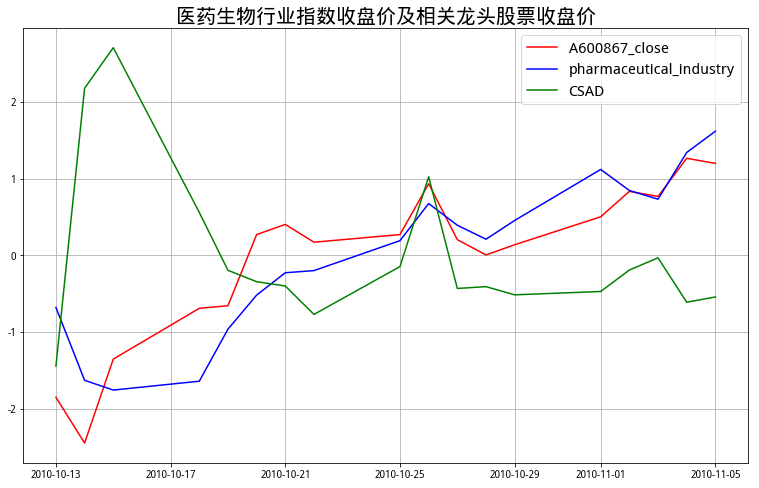

In [110]:
###展示医药生物指数收盘价、相关龙头股收盘价及离散程度
t0 = time.time()
"获取申万一级医药生物行业在10年11月6号之前的成份分股代码"
pharmaceutical_industry_stock = get_industry_stocks('801150',date='2010-11-06')

###根据成份股，获取出该段时间内每日每股的股价###
pharmaceutical_industry = pd.DataFrame([])
for i in pharmaceutical_industry_stock:
    close = get_price(i,start_date='2010-10-13',end_date='2010-11-06',fields='close')
    pharmaceutical_industry[i]=close.close
print('')
print('医药生物行业在10年10月13到11月06这段时间内每股每日的收盘价')
display(pharmaceutical_industry.tail())

    
"获取医药生物龙头股通化东宝收盘价"
A600867 = get_price('600867.XSHG',start_date='2010-10-13',end_date='2010-11-06')
CriValue_600867=finance.run_query(query(finance.SW1_DAILY_PRICE
                          ).filter(finance.SW1_DAILY_PRICE.code=='801150',
                                    finance.SW1_DAILY_PRICE.date < '2010-11-06',
                                    finance.SW1_DAILY_PRICE.date > '2010-10-12'))
###统一日期索引###
CriValue_600867.index=A600867.index  
    
    
"计算医药生物板块指数与市场回报率的截面绝对离散程度"

###利用申万一级行业的医药生物板块的所有成分股，先输出每只成分股的收益率数据，再进行绝对加总运算。

###如果仅使用医药生物行业的指数收益率作为T时刻股票组合的截面收益率的话，会收到指数加权算法的影响，
###导致较大的误差

pharmaceutical_industry_rate = pharmaceutical_industry.pct_change(1).fillna(0)###获取医药生物板块横截面收益率
CSAD_list = pd.DataFrame([0]*len(pharmaceutical_industry_rate))
for i in range(len(pharmaceutical_industry_rate)):
    CSAD = abs(pharmaceutical_industry_rate.iloc[i,:]-CSMAR_market_sample.Market_return_rate[i]).sum(
                                )/len(pharmaceutical_industry_rate.iloc[i,:])
    CSAD_list.iloc[i,:] = CSAD
    
    
###运用sklearn的模块进行归一化###
A600867_close = scale(A600867.close)
pharmaceutical_industry = scale(CriValue_600867.close)
CSAD = scale(CSAD_list)
market_sample_rate = scale(CSMAR_market_sample.Market_return_rate)

dataframe = pd.DataFrame([A600867_close,pharmaceutical_industry,CSAD
                 ],index=['A600867_close','pharmaceutical_industry','CSAD']).T

###统一日期索引###
dataframe.index=CriValue_600867.index 
print('')
print('医药生物指数收盘价、相关龙头股收盘价及离散程度的数据表格')
display(dataframe.tail())
    

t1 = time.time()
print('获取数据完成 耗时 %s 秒' %round((t1-t0),3))  
print('')
fig = plt.subplots(figsize=(13,8))
plt.plot(dataframe.A600867_close,'r')
plt.plot(dataframe.pharmaceutical_industry,'blue')
plt.plot(dataframe.CSAD,'g')
plt.grid(True)
plt.title('医药生物行业指数收盘价及相关龙头股票收盘价',fontsize=20)
plt.legend(['A600867_close','pharmaceutical_industry','CSAD'],fontsize=15) 
plt.show()
    



2010年10月，医药生物行业龙头股通化东宝大涨，随后行业指数也跟着跟风上涨。

上图可以很直观地看出，在10月15日通化东宝大涨后，医药板块指数收益率与上证指数收益率的离散程度明显变大，而在之后医药板块股跟风上涨后，离散程度逐渐减少。


# 对A股综合日市场回报率指标进行构建

本文构建的市场回报率计算公式为：

    上证A股指数的收益率*上证A股的总流通市值占比
                     +
    深证A股指数的收益率*深证A股的总流通市值占比
而总流通市值 = 当日指数成份股流通市值的总和

In [159]:
###计算深证A股每日的流通市值
t0 = time.time()
def get_SZ_CriValue():
    A399107 = get_index_stocks('399107.XSHE',date='2019-09-01')
    A399107_market_value = pd.DataFrame([])
    for i in A399107:
        q = query(valuation.circulating_market_cap).filter(valuation.code==i)
        panel = get_fundamentals_continuously(q, end_date='2019-09-01', count=3100)
        stock_market = panel.minor_xs(i)
    ###删除后缀的原因是本文作者常用数据库时Mongodb，存入数据库的columns不能有点###
        stock = i[0:6]
        A399107_market_value[stock]=stock_market.circulating_market_cap

    ###计算每日的总流通市值###
    A399107_market_value = A399107_market_value.fillna(0)
    A399107_market_value['market_cap']=[0]*len(A399107_market_value)
    for i in range(len(A399107_market_value.index)):
        A399107_market_value['market_cap'][i]=A399107_market_value.iloc[i,:].sum()
        
    return A399107_market_value

A399107 = get_SZ_CriValue()
t1 = time.time()
print('获取数据完成 耗时 %s 秒' %round((t1-t0),3))  
print('')    
print('表4————深证A股07年1月至29年9月01的成份股流通市值每日数据')
print("")
display(A399107.tail())
    

获取数据完成 耗时 1377.645 秒

表4————深证A股07年1月至29年9月01的成份股流通市值每日数据



,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000023,000025,000026,000027,000028,000029,000030,000031,000032,000034,000035,000036,000037,000038,000039,000040,000042,000043,000045,000046,000048,000049,...,300747,300748,300749,300750,300751,300752,300753,300755,300756,300757,300758,300759,300760,300761,300762,300763,300765,300766,300767,300768,300769,300770,300771,300772,300773,300775,300776,300777,300778,300779,300780,300781,300782,300783,300785,300786,300787,300788,300789,market_cap
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-26,2446.7600,2569.6626,16.6945,34.2775,72.6738,28.6395,89.6698,128.9725,18.6387,54.2236,84.6112,20.5538,77.1145,15.4520,11.3497,27.8280,20.3268,189.6940,20.0086,92.0672,28.3233,239.0588,155.3801,97.8151,78.3442,116.0783,42.6912,72.4816,77.2497,67.1136,45.0051,26.7730,148.6776,54.0774,60.9888,95.2848,35.0075,234.9545,93.2582,79.6551,...,86.6385,29.4986,6.5510,871.0978,20.1500,10.3063,7.6396,22.1887,6.7122,7.5114,7.7159,28.9888,212.7878,28.1158,20.3496,7.264,17.175,14.5002,6.418,13.9675,10.1256,26.6944,14.6150,9.8550,22.0855,18.7101,22.1582,14.2476,9.280,9.1550,8.2654,7.9215,72.8825,18.9707,12.3893,6.9700,13.3177,17.2800,0.0000,159198
2019-08-27,2457.0623,2576.4631,16.8604,33.5369,72.4041,31.5127,90.9693,125.6655,18.5343,54.1709,84.0250,20.2915,78.2321,15.6338,11.3531,27.8696,20.2905,182.2003,19.7589,89.3571,28.5016,237.4730,158.8884,97.8151,81.4825,116.6224,43.5549,71.5106,75.9686,67.4086,45.9540,29.4549,153.4094,55.0317,61.2537,101.8860,35.1903,242.1883,96.2120,79.8193,...,90.8307,28.5168,6.7306,877.4422,20.2189,10.0854,7.8053,22.5708,6.7896,7.6284,7.8919,29.4154,222.0416,28.4997,20.7633,7.420,17.750,14.7127,6.484,14.2316,10.1972,26.9640,14.6800,10.0167,22.7937,20.5831,22.4427,15.0158,9.204,9.2825,8.3901,8.1688,73.8500,19.0445,12.5427,7.0515,12.7978,17.6366,0.0000,162166
2019-08-28,2450.1941,2579.3777,16.8687,33.2195,72.2693,28.3614,90.5226,121.0866,17.9078,54.6447,82.6571,20.2915,73.2828,17.2093,11.2536,27.6200,20.0912,175.0004,19.3565,87.9823,28.2519,239.0588,149.1637,97.8151,81.8345,116.4410,42.7735,69.6658,75.3281,67.4086,46.7674,32.4118,150.6700,53.9713,61.3199,102.5528,35.4645,238.5659,96.6724,78.4031,...,90.5453,27.6224,6.6280,868.1051,19.6170,9.6116,7.5790,22.7387,6.6636,7.6882,7.9987,28.8641,221.2026,28.9125,21.4872,7.580,17.630,15.0896,6.638,14.7917,10.2464,28.1356,14.9800,10.2592,23.0978,22.6394,22.3732,16.5161,9.354,9.4425,8.8998,8.3802,76.1675,20.9510,13.1733,7.3652,12.8699,19.4002,5.8926,161890
2019-08-29,2426.1558,2523.0298,16.8687,33.5369,73.0783,26.5695,90.2632,122.1042,17.9078,55.9608,82.4617,20.6546,73.4424,18.9363,11.0544,28.0776,20.7434,176.7637,19.8144,86.7647,28.0736,235.0944,148.9483,97.8151,80.6025,115.8969,44.6243,70.0056,74.8156,67.5561,50.1563,35.6438,150.0612,53.3351,63.9688,100.6858,36.3328,231.8384,91.8388,78.4031,...,90.2009,28.7040,6.6331,850.8675,18.9644,9.6465,7.5144,23.0928,6.9300,7.5998,7.8786,27.7484,217.7613,29.3253,20.9367,7.592,17.560,16.1844,6.634,15.2038,10.1427,29.0826,14.6600,10.1784,22.7657,22.6344,22.0805,15.6439,8.936,9.1050,8.6871,8.0314,80.0000,19.9424,12.7320,7.1356,11.8832,19.8708,6.4814,161650
2019-08-30,2431.3069,2506.5139,16.3887,32.7963,71.4603,24.7158,89.7445,117.0165,17.5946,53.0128,81.2893,19.6057,70.2493,17.0578,10.4568,26.9129,20.0007,159.5689,18.8015,83.0726,28.0379,233.9050,146.3632,97.8151,79.7226,115.3528,42.0743,67.9181,73.4064,65.9335,46.6657,34.7957,151.1265,54.0774,62.0484,105.7534,34.0477,225.6285,94.1996,75.5913,...,89.9352,30.3098,6.5202,865.1125,18.6212,9.2163,7.4639,22.5500,6.6798,7.3866,7.6385,27.4202,226.6016,28.9001,20.5998,7.416,16.830,15.5588,6.388,14.4876,10.2710,29.4357,14.3475,9.8550,22.3856,24.8989,22.1252,16.1120,8.974,8.8225,8.2691,7.2515,76.0000,20.0449,12.1600,7.0061,11.8195,19.1720,7.1300,160491


In [111]:
##计算上证A股每日的流通市值
t0 = time.time()
def get_SH_CriValue():
    A000002 = get_index_stocks('000002.XSHG',date='2019-09-01')
    A000002_market_value = pd.DataFrame([])
    for i in A000002:
        q = query(valuation.circulating_market_cap).filter(valuation.code==i)
        panel = get_fundamentals_continuously(q, end_date='2019-09-01', count=3100)
        stock_market = panel.minor_xs(i)
        stock = i[0:6]
        A000002_market_value[stock]=stock_market.circulating_market_cap

    A000002_market_value = A000002_market_value.fillna(0)
    A000002_market_value['market_cap'] = [0]*len(A000002_market_value)
    for i in range(len(A000002_market_value.index)):
        A000002_market_value['market_cap'][i]=A000002_market_value.iloc[i,:].sum()
        
    return A000002_market_value
        
A000002 = get_SH_CriValue()
t1 = time.time()
print('获取数据完成 耗时 %s 秒' %round((t1-t0),3))  
print('')    
print('表5————上证A股07年1月至29年9月01的成份股流通市值每日数据')
print("")
display(A000002.tail())

获取数据完成 耗时 2946.452 秒

表5————上证A股07年1月至29年9月01的成份股流通市值每日数据



,600000,600004,600006,600007,600008,600009,600010,600011,600012,600015,600016,600017,600018,600019,600020,600021,600022,600023,600025,600026,600027,600028,600029,600030,600031,600033,600035,600036,600037,600038,600039,600048,600050,600051,600052,600053,600054,600055,600056,600057,...,603922,603926,603928,603929,603933,603936,603937,603938,603939,603955,603956,603958,603959,603960,603963,603966,603967,603968,603969,603970,603976,603977,603978,603979,603980,603982,603983,603985,603986,603987,603988,603989,603990,603991,603993,603996,603997,603998,603999,market_cap
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-26,3175.7253,389.2392,93.0,161.2659,159.5623,949.5749,471.9905,678.30,63.1755,932.2093,2049.7107,92.5772,1334.8037,1292.9136,97.3112,186.1366,162.0089,546.7477,425.8656,192.6167,279.8297,4749.2212,466.3040,2180.8179,1148.9622,83.9786,50.8392,7220.1304,130.2704,278.4099,114.0834,1717.8197,1265.4368,18.4663,25.2819,93.8182,46.6590,58.6786,142.2051,90.3973,...,5.0272,9.7558,7.5765,13.9046,6.8174,51.3273,8.2534,8.7251,280.7982,10.7408,7.1434,15.8890,46.0992,18.4609,12.9372,8.9940,12.0533,32.8804,33.5559,12.3316,6.5340,14.5864,26.4827,51.0482,28.9552,10.800,20.1720,14.1453,321.3054,21.1625,23.1202,73.2034,23.0613,7.7721,635.9678,13.0565,48.9068,33.8031,35.0208,275548
2019-08-27,3175.7253,390.8946,95.6,163.9856,162.4547,956.7918,478.3259,679.35,63.8749,929.6448,2063.8955,94.4226,1360.2947,1315.0146,99.7833,187.7797,164.1982,552.1880,433.0080,195.6263,281.9284,4768.3330,478.9447,2234.7986,1153.1311,84.5275,51.7083,7168.5581,133.6107,281.2393,115.8119,1709.4923,1280.2744,18.8393,27.8101,93.3413,47.2236,58.2459,142.2051,91.4761,...,5.0848,9.8503,7.7146,14.0688,6.8074,49.8484,8.4127,8.8267,275.5391,10.8050,7.2839,16.1281,48.9530,18.4609,13.2549,9.2099,11.9600,33.0849,34.2287,12.5895,6.8902,14.9383,25.9499,51.3399,29.6086,11.425,19.6800,14.2385,342.8951,21.0060,23.3554,74.2954,22.9769,7.9036,648.3339,13.1766,49.9810,34.6535,34.9056,279034
2019-08-28,3181.3462,392.1362,100.4,164.7914,163.9009,936.1251,478.3259,664.65,64.5742,934.7739,2067.4419,92.5772,1346.3905,1301.7540,98.8844,186.1366,166.3876,549.4679,431.2224,195.3527,274.9327,4758.7769,465.6017,2200.4473,1130.6188,84.5275,51.7083,7116.9858,132.6364,282.2415,115.8119,1695.2168,1256.9583,18.7150,30.5998,91.7806,47.7882,57.0020,135.2214,91.9075,...,5.1008,9.8331,7.7837,13.9240,6.7168,48.7010,8.3975,8.7099,274.7775,10.8407,7.6801,16.3020,49.3481,18.3060,12.8677,9.3132,11.7533,33.1667,34.4810,12.6660,6.7599,14.7976,27.6169,50.5232,29.6430,11.850,20.0408,14.4994,338.6618,20.3797,22.9790,75.0754,23.6266,7.8830,637.7344,13.1466,52.3189,32.4850,33.4080,278173
2019-08-29,3156.0527,393.7917,97.6,161.6688,162.9368,924.6436,471.9905,660.45,64.6908,930.9271,2067.4419,91.9621,1360.2947,1295.1237,97.7607,186.6061,164.1982,546.7477,419.6160,196.4472,267.2374,4768.3330,464.8994,2183.7622,1122.2809,84.5275,51.7083,6999.4009,135.0025,281.9467,115.4662,1630.9771,1261.1975,18.7772,33.6511,91.4338,47.4802,58.1918,135.2214,91.9075,...,5.0752,9.7816,7.7334,13.9143,6.7722,51.6333,8.3823,8.6388,279.4925,10.7337,7.5054,16.6715,50.5335,18.2319,12.5897,9.4165,11.7267,33.9232,34.9015,12.5418,6.7867,14.8152,28.1650,50.4648,29.8149,11.560,19.9711,14.8442,347.3824,20.4580,22.9790,74.5294,23.3566,7.9734,632.4347,13.8069,51.3711,34.3984,33.6960,277698
2019-08-30,3170.1045,386.9629,93.8,165.4965,161.4906,919.0669,475.1582,661.50,63.8749,928.3625,2060.3494,90.7318,1330.1689,1284.0732,96.1875,186.1366,163.1036,544.0276,407.1168,195.0791,263.0399,4758.7769,461.3881,2190.6326,1123.1147,84.5275,50.3355,7071.6021,132.0797,283.5383,115.1205,1600.0468,1240.0009,18.9948,37.0510,89.7863,46.9156,57.1643,132.9947,91.4761,...,5.0176,9.6526,7.6016,13.9819,6.5659,49.3384,8.2761,8.5423,277.8241,10.6053,7.2797,15.9760,47.3285,18.0501,12.2819,9.3789,11.3400,33.2280,34.3969,12.3507,6.7484,15.2550,27.4647,49.3564,28.7145,10.980,20.4631,14.2944,371.2580,20.0405,22.5557,71.4874,23.3735,7.883

In [109]:
###运用流通市值加权平均法计算Rm###
sz = pd.DataFrame(A399107.market_cap)
sh = pd.DataFrame(A000002.market_cap)
real_market = pd.concat([sz,sh],axis=1)
real_market.columns = ['深证','上证']
real_market.index = A000002.index
real_market['all'] = real_market['深证'] + real_market['上证']


ASH_market_return = get_price('000002.XSHG',start_date='2006-12-06',end_date='2019-09-01',fields='close'
                             ).pct_change(1).fillna(0)
ASZ_market_return = get_price('399107.XSHE',start_date='2006-12-06',end_date='2019-09-01',fields='close'
                             ).pct_change(1).fillna(0)
real_market['R深证'],real_market['R上证'] = ASZ_market_return,ASH_market_return


Rm = (real_market['深证']/real_market['all'] * real_market['R深证']
                               )+(
      real_market['上证']/real_market['all'] * real_market['R上证'])


Rm = Rm[Rm.index>='2007-01-01']

下文对本文构建的Rm与数据库的Rm进行方差对比分析

In [113]:
Rm_sample = Rm[(Rm.index>'2008-12-31')&(Rm.index<='2010-12-31')]

###计算构建的A股综合日市场回报率指标的方差###
Rm_sample_Var = np.var(Rm_sample)
print('本文构建的Rm的方差=%s'%Rm_sample_Var)
print('')

###计算国泰安数据库的A股综合日市场回报率指标的方差###
CSMAR_Var = np.var(CSMAR_market.Market_return_rate)
print('国泰安数据库的Rm的方差=%s'%CSMAR_Var)
print('')

###计算两个指标的相关性###
corr = Rm_sample.corr(CSMAR_market.Market_return_rate)
print('两个指标的相关性=%s'%corr)

本文构建的Rm的方差=0.0002943865102120661

国泰安数据库的Rm的方差=0.0003270577424096557

两个指标的相关性=0.9939454378091903


    根据两个指标的方差，本文构建的综合日市场回报率指标比CSMAR的指标更平稳，但是还是存在较大误差，不能很好的复现出CSMAR的指标。
    
    
于此，本文开始寻找改良本文构建的Rm的方法，寻找改良方法的原因如下：
    
        第一：国泰安数据库能免费提供的数据时间过短，只免费提供能到10年12月份，要获取最新的数据成本过大。
    
        第二：本文构建的Rm占用内存过多，文件太大，两个dataframe保存到excel的话文件大小是60M。其次基于本文作者穷苦生活现状分析，用积分去升级配置有点得不偿失，积分用的过于浪费，所以寻求更简便的方法计算Rm。
    
        第三：信号分布上和原有研报的分布还是存在差异，猜测是构建的指标方差与原文的方差差距过大。而方差过大的原因，本文分析是因为幸存者偏差，因为在获取上证和深证的成份股列表时，是使用2019年9月1日的上深两的成份股信息，由于指数成份股是会定期调整的，所有当前的成份股不代表就是过去成份股。而不获取过去成份股信息的原因是数据量太大，不好去整合分析，所以下文寻求替代方法。
        
        第四：目前，本文构建的Rm不仅存在幸存者偏差，而且没有考虑到现金红利再投资的影响，从本文求出的A股两市流通市值和真实的流通市值对比就可以发现差异，所以需要进行改良。
（替代方法的详情会在下两节在原有研报思路改进上会详细说明。）

（需要注意的是数据量的问题在聚宽的回测引擎中中是可以解决的。在回测引擎回测时输出当日的成份股，再得到收益率，计算出横截面收益率，这样就不需要保存数据在文件中，方便很多。）

# 计算替代A股综合日市场回报率

计算公式=（上A指数收益率+深A指数收益率）/2

意思就是不对流通市值进行加权平均。

In [6]:
ASH_market_rate_sample = get_price('000002.XSHG',start_date='2008-12-31',end_date='2010-12-31',fields='close'
                                  ).pct_change(1).dropna()
ASZ_market_rate_sample = get_price('399107.XSHE',start_date='2008-12-31',end_date='2010-12-31',fields='close'
                                  ).pct_change(1).dropna()

Sub_Rm_sample = (ASZ_market_rate_sample+ASH_market_rate_sample)/2

###计算构建的A股综合日市场回报率指标的方差###
Sub_Rm_Var = np.var(Sub_Rm_sample.close)
print('本文构建的改良Rm的方差=%s'%Sub_Rm_Var)
print('')

###计算国泰安数据库的A股综合日市场回报率指标的方差###
CSMAR_Var = np.var(CSMAR_market.Market_return_rate)
print('国泰安数据库的Rm的方差=%s'%CSMAR_Var)

本文构建的改良Rm的方差=0.000310483931975519

国泰安数据库的Rm的方差=0.00032638478409194034


上文代码可以看出在09年1月1日到10年12月31日期间

    国泰安数据库的A股综合日市场回报率的方差与构建的改良上证A股和深证A股的平均市场回报率的方差相差不大，比原有构建的指标方差差距更小了，相关性也是几乎等于1。惊喜，可以用更少内存占比得出更接近CSMAR的Rm的指标！！！

    证明，改良的市场回报率指标能更好复现CSMAR的市场回报率，可以运用上A和深A的平均市场回报率代替数据库的市场回报率的。

    但是其缺点就是替代市场回报率没有对上A和深A的流通市值进行加权平均去计算市场回报率，所以会与数据库的市场回报率相比会有所偏差。

（下文的市场回报率都将使用改良的市场回报率—Sub_Rm）

# 研报中对模型改进章节的复现

In [209]:
def get_stocks_interval(code,interval_time):
    """简述get_stocks_interval（）函数需要输入的参数和返回值
参数：code = 标的指数的代码（有后缀），不能是单只股票，因为要根据code去获取标的指数的成份股。
     interval_time = 间隔时间。每个标的指数的成份股会定期调整一次，所以需要输入时间列表去获取调整后的成份股。
返回值：stock_timelist = 标的指数code在每个时间段内（interval_time）的成份股表格
    """
    datetime = interval_time
    stock_timelist = []
    if len(code)==11:
        for h in datetime:
            index_list = get_index_stocks(code,date=h)
            stock_timelist.append(index_list)
        stock_timelist = pd.DataFrame(stock_timelist).T
        ###将列名改为每年的1月1日###
        stock_timelist.columns = datetime
        
    elif len(code)==6:
        for h in datetime:
            industry_list = get_industry_stocks(code,date=h)
            stock_timelist.append(industry_list)
        stock_timelist = pd.DataFrame(stock_timelist).T
        ###将列名改为每年的1月1日###
        stock_timelist.columns = datetime
        
        
    return stock_timelist

In [210]:
def get_stocks_section(stocks,interval_time):
    """简述get_stocks_section()函数需要输入的参数和返回值
参数：stocks = dataframe，内容是get_stocks_interval的返回值，输入每年的成份股数据表格
     interval_time = 同上文的interval_time，回测的时间间隔，每个时间段间相隔一年。         
返回值：stock_CSAD_section = 返回一个dataframe，包含每天所有成份股的横截面绝对离散程度CSAD。
    """
    datetime = interval_time
    start = datetime[0]
    end = datetime[-1]
    stocks_timelist = stocks
    
    """使用改良的A股综合日市场回报率指标"""
    ASH_market_rate = get_price('000002.XSHG',start_date=start,end_date=end,fields='close'
                               ).pct_change(1).fillna(0)
    ASZ_market_rate = get_price('399107.XSHE',start_date=start,end_date=end,fields='close'
                               ).pct_change(1).fillna(0)
    Sub_Rm = (ASZ_market_rate+ASH_market_rate)/2
    

    """获取每个时间段的成份股数据"""
    
    
    """计算标的指数每天的横截面绝对离散程度"""
    stocks_CSAD = pd.DataFrame([],columns=['CSAD'])
    for i in range(len(stocks_timelist.columns)-1):###？？？为何要减1请看下文###
        
        ###用每年标的指数成份股获得当年内的所有成份股的收益率###
        year = stocks_timelist.columns[i+1]
        
        ###过滤掉None，因为在有些标的指数每个时间段内的成份股数量是不同的，返回的len也不同，合在一起时就会出现None###
        current_stock = list(filter(None,stocks_timelist[year]))  
        stocks_rate = pd.DataFrame([],columns=['CSAD'])
        
        
        """第一个for循环是对stocks_rate这个表格的每一列输入每只股票的收盘价再转换成收益率"""
        for k in current_stock:
            if stocks_timelist.columns[i] != end :
                
                ###当stocks_timelist得第i个值等于最后一个column时，第i+1个值是不存在###
                stock_close = get_price(k,start_date = stocks_timelist.columns[i]
                                          ,end_date = stocks_timelist.columns[i+1]
                                          ,fields='close')
                stocks_rate[k] = stock_close.close
            elif stocks_timelist.columns[i] == end:
                pass 
        stocks_rate = stocks_rate.pct_change(1).fillna(0)
        
        
        """第二个for循环是对stocks_rate表格每一行即每天所有成份股的收益率矢量操作减去Sub_Rm
        最后求出当天标的指标的横截面绝对离散程度"""
        for j in range(len(stocks_rate)):
            
            ###iloc返回的是Series，Series的name等于一个交易日，格式是timestamp###
            times = stocks_rate.iloc[j,:].name.strftime('%Y-%m-%d')
            
            ###计算横截面绝对离散程度###
            stocks_section_CASD = abs((stocks_rate.iloc[j,1:]-Sub_Rm.loc[times].values)).sum(
                                        )/len(stocks_rate.iloc[j,1:])

            stocks_rate.CSAD[j] = stocks_section_CASD
            
        CSAD_data = pd.DataFrame(stocks_rate.CSAD)
        stocks_CSAD = stocks_CSAD.append(CSAD_data)
    
    return stocks_CSAD


In [211]:
###获取07年至19年的标的指数每年的股票列表去计算当年每天得横截面绝对离散程度，避免幸存者偏差###
interval_time = ['2007-01-01','2008-01-01','2009-01-01','2010-01-01'
                ,'2011-01-01','2012-01-01','2013-01-01','2014-01-01'
                ,'2015-01-01','2016-01-01','2017-01-01','2018-01-01'
                ,'2019-01-01','2019-09-01']
t0 = time.time()
###用沪深300进行分析###
stocks = get_stocks_interval('000300.XSHG',interval_time)
HS300_CSAD_section = get_stocks_section(stocks,interval_time)
t1 = time.time()
print('获取数据完成 耗时 %s 秒' %round((t1-t0),3))
print('')    
display(HS300_CSAD_section.tail())

获取数据完成 耗时 29.283 秒



,CSAD
2019-08-26,0.012594
2019-08-27,0.012630
2019-08-28,0.011762
2019-08-29,0.011240
2019-08-30,0.012680


In [147]:
def get_stocks_belta(target_CSAD,interval_time):  
    """简述get_target_belta()的参数和返回值
参数: target_CSAD = 必须是get_stocks_section的返回值
    interval_time = 最好等于输入进get_target_section的interval_time。不过该函数内只会用到第一个值和最后一个值
                    当作start_time和end_time,所以也可以输入进一个包含两个时间字符串的列表。  
返回值： belta = 用OLS回归后得到的二次项系数，格式是dataframe
    """

    ###额，好吧。改良市场回报率指标我打包放进了get_industry_section函数里面##
    ###为了方便大家调出，这里再打包计算一次###
    datetime = interval_time
    start = datetime[0]
    end = datetime[-1]
    target_CSAD = target_CSAD
    
    """计算改良A股综合日市场回报率指标"""
    ASH_market_rate = get_price('000002.XSHG',start_date=start,end_date=end,fields='close'
                                   ).pct_change(1).fillna(0)
    ASZ_market_rate = get_price('399107.XSHE',start_date=start,end_date=end,fields='close'
                                   ).pct_change(1).fillna(0)
    Sub_Rm = (ASZ_market_rate+ASH_market_rate)/2

    
    """计算二次项系数β2"""
    CSAD = target_CSAD.CSAD
    x1=[]
    x2=[]
    market_data = abs(Sub_Rm)
    for i in range(len(CSAD))[22:]:

        x=market_data.iloc[i-22:i]
        y=CSAD.iloc[i-22:i]
        X = np.column_stack((x**2, x))
        X = sm.add_constant(X)

        model = sm.OLS(y,X)
        results = model.fit()
        x1.append(results.params[1])
        x2.append(results.params[2])
        #print(results.summary())
    
    belta = pd.DataFrame(x1,index = CSAD.index[22:],columns=['x1'])
    return belta


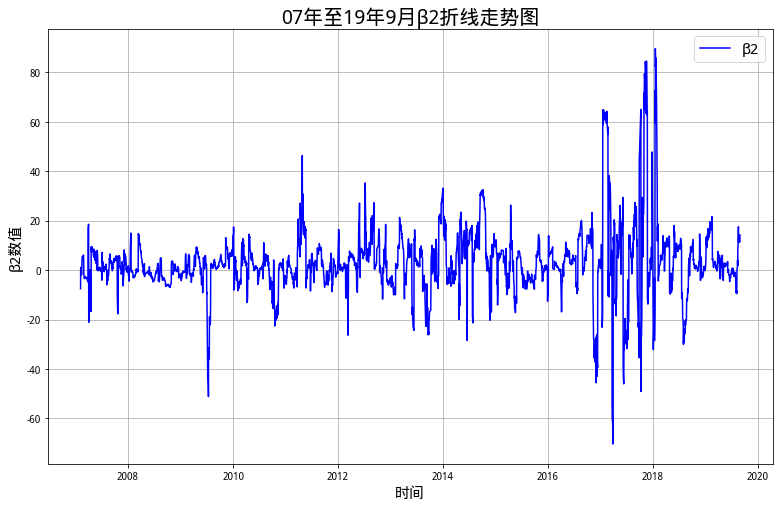

In [6]:
HS300_belta = get_stocks_belta(HS300_CSAD_section,interval_time)

fig=plt.subplots(figsize=(13,8))
plt.plot(HS300_belta,'b')
plt.grid(True)
plt.title('07年至19年9月β2折线走势图',fontsize=20)
plt.legend(['β2'],fontsize=15)
plt.xlabel('时间',fontsize=15)
plt.ylabel('β2数值',fontsize=15)
plt.show()


解读β2显著为负

    样本不在总体的95%的置信区间内，则判断样本∈拒绝域。而置信区间存在双侧置信区间和单侧置信区间，当用于解读显著为负时，我们只需要考虑单侧的情况，单侧置信区间则为（θ_ ,+∞），则应该运用单侧置信区间的下限——θ_，去判断是否显著为负，若当日的β2∉（θ_ ,+∞），则判断β2显著为负。
    
    而计算单侧置信区间的下限，则运用分位数去计算。
    即总体的2.5%的分位数既是单侧置信区间的下限。
    当当日β值小于总体（180天的β值）的单侧置信区间下限时则判断该样本显著为负。

In [148]:
def get_analysis_frame(target_code,belta_frame,interval_time):
    """ 简述get_analysis_frame（）函数的参数和返回值
参数：target_code = 标的指数的代码,格式为字符串
      belta_frame = get_stocks_belta的返回值，      interval_time = 同上文
返回值：belta = 一个dataframe，包含标的指数的belta，MA5,MA10,MA20,滚动22天平均收益率，滚动180天2.5%，5%，10%的分位数。
"""   
    code= target_code
    belta = belta_frame
    belta = pd.DataFrame(belta,columns=[code])
    start = interval_time[0]
    end = interval_time [-1]
    
    
    if len(code)==11:
        target = get_price(code,start_date=start,end_date=end,fields='close')
        R_target = target.pct_change(1).fillna(0)
    elif len(code)==6:
        q = finance.run_query(query(finance.SW1_DAILY_PRICE
                                          ).filter(finance.SW1_DAILY_PRICE.code==code,
                                                   finance.SW1_DAILY_PRICE.date > start,
                                                   finance.SW1_DAILY_PRICE.date < end))
        
        target = pd.DataFrame(list(q.close),index=q.date,columns=['close'])
        R_target = target.pct_change(1).fillna(0)
        
    R_MA22 = R_target.rolling(22,min_periods=22).mean()
    MA30 = target.rolling(30,min_periods=30).mean()
    MA10 = target.rolling(10,min_periods=10).mean()
    MA5 = target.rolling(5,min_periods=5).mean()
    
    belta['MA5'] = MA5
    belta['MA10']= MA10
    belta['MA30']= MA30
    belta['R_MA22'] = R_MA22
    belta['quantile-0.1'] = belta[code].rolling(180,min_periods=180).quantile(0.1)
    belta['quantile-0.05'] = belta[code].rolling(180,min_periods=180).quantile(0.05)
    belta['quantile-0.025'] = belta[code].rolling(180,min_periods=180).quantile(0.025)
    
    """为了避免过拟合的情况，分位数的计算方式为向前滚动计算180天的分位数
    180天即半年，是许多标的指数成份股的调整周期
    """
    
    belta = belta.fillna(method = 'bfill')
    
    return belta

In [10]:
name = '000300.XSHG'
HS300_belta.columns=[name]
x1_negative = get_analysis_frame(name,HS300_belta[name],interval_time)
R_300 = get_price('000300.XSHG',start_date='2007-01-01',end_date='2019-09-01',fields=['low','close'])

,000300.XSHG,MA5,MA10,MA30,R_MA22,quantile-0.1,quantile-0.05,quantile-0.025
2017-03-27,-62.313025,3469.204,3464.328,3454.561000,0.000074,-29.305861,-35.988965,-41.407554
2017-03-29,-59.146374,3472.924,3465.795,3457.144000,0.000261,-30.713346,-37.245595,-50.523862
2018-08-01,-30.015120,3507.522,3514.405,3479.353333,0.000595,-11.334972,-19.665199,-25.905180
2018-08-07,-29.376146,3355.154,3444.374,3447.184000,0.000157,-13.448930,-25.006846,-28.464761
2019-06-19,-4.652434,3675.730,3656.156,3652.650000,0.000885,-1.495174,-2.895318,-3.429257



单侧置信区间下限为百分之2.5的belta信号总共出现了85次



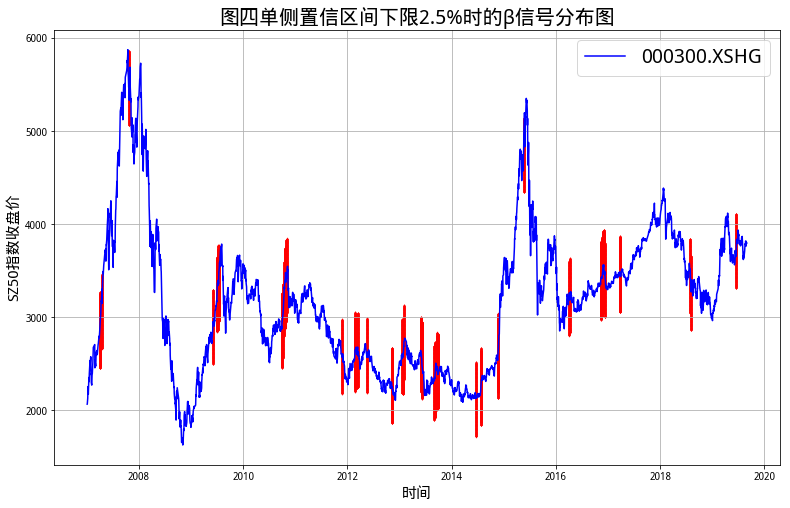

In [11]:
###单侧置信区间下限为百分之2.5时belta信号的分布状况
signal_01 = pd.DataFrame([])

for i in range(len(x1_negative)):
    if x1_negative[name][i]<x1_negative['quantile-0.025'][i    ###筛选出小于单侧置信区间2.5%下限的值###
        ] and x1_negative.R_MA22[i]>0:                         ###筛选出22天平均收益率大于0的值###
        
        signl = pd.DataFrame(x1_negative.iloc[i,:]).T
        signal_01 = signal_01.append(signl)

display(signal_01.tail())
print('')
print('单侧置信区间下限为百分之2.5的belta信号总共出现了%s次'%len(signal_01))
print('')

###信号坐标##
Y = R_300.loc[signal_01.index].low
X = signal_01.index

fig = plt.subplots(figsize=(13,8))
plt.plot(R_300.close,'b')
plt.grid(True)
plt.title('图四单侧置信区间下限2.5%时的β信号分布图',fontsize=20)


"""本来是完整的复现研报那样画出长竖直线的，但是发现最细的线条也是挺宽的"""
"""再加上信号点有点多,全部放在图片上的话有点小丑，所以就缩短直线的长度，尽可能美观点"""
for x in X:
    loc = int(Y.loc[x])
    c = range(loc-400,loc+400)
    plt.scatter([x]*len(c),c,color='r',marker='.',s=1)
plt.legend(['000300.XSHG'],fontsize=20)
plt.xlabel('时间',fontsize=15)
plt.ylabel('SZ50指数收盘价',fontsize=15)
plt.show()

# 在原有研报的思路上进行尝试和改进

第一小节:关于单侧置信区间下限的改进
    
    对于原始的置信区间，2.5%的单侧置信区间下限去计算时，会发现在07年至19年间信号量少得只有85次，策略总体的频率较低，有一大部分时间策略是处于空仓状态。
    因此，本小节以增加信号量，提高策略开仓频率为目的进行改进。
    改进的方法为提高优化单侧置信区间下限，得到更多的β2显著为负的信号。
    **优化后的单侧置信区间下限为10%，单侧置信区间为90%。

单侧置信区间下限为百分之10的belta信号总共出现了257次



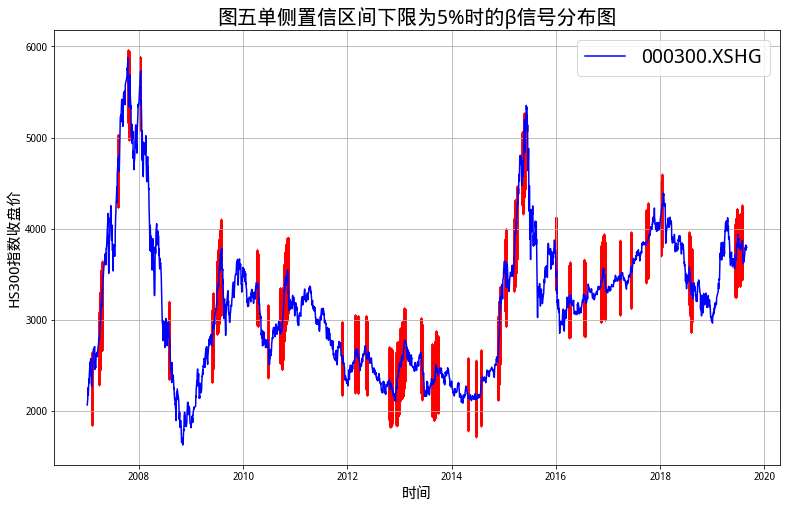

In [12]:
###单侧置信区间下限为百分之10时belta信号的分布状况

signal_02 = pd.DataFrame([])
for i in range(len(x1_negative)):
    if x1_negative[name][i]<x1_negative['quantile-0.1'][i   ###筛选出小于单侧置信区间10%下限的值###
        ] and x1_negative.R_MA22[i]>0:                      ###筛选出22天平均收益率大于0的值###
        
        signl = pd.DataFrame(x1_negative.iloc[i,:]).T
        signal_02 = signal_02.append(signl)
print('单侧置信区间下限为百分之10的belta信号总共出现了%s次'%len(signal_02))
print('')


###增加过滤指标后的信号坐标###
Y = R_300.loc[signal_02.index].low
X = signal_02.index


fig = plt.subplots(figsize=(13,8))
plt.plot(R_300.close,'b')
plt.grid(True)
plt.title('图五单侧置信区间下限为5%时的β信号分布图',fontsize=20)

for x in X:
    loc = int(Y.loc[x])
    c = range(loc-400,loc+400)
    plt.scatter([x]*len(c),c,color='r',marker='.',s=1)
plt.legend(['000300.XSHG'],fontsize=20)
plt.xlabel('时间',fontsize=15)
plt.ylabel('HS300指数收盘价',fontsize=15)
plt.show()

        可以看出在提高单侧置信区间下限后，我们发现得出的信号更多了，期间总共出现了257次显著性信号。
        事实上，策略的频率提高了，显著性信号增加了，但出现的问题是信号更加混杂了。
        在08年熊市市场大幅度，出现了下跌羊群效应，但是判断市场趋势的指标却判断为上涨市场，这样会使得策略的回撤大大增加，收益率减少。
        为此，下一小节会着重于对市场趋势指标的改进。

第三小节：关于判断市场趋势的过滤指标的改进

        在基于上一小节改进的基础上，本小节对市场趋势的过滤指标进行改进。原有研报是使用22日内指数平均收益率的正负区间去判断市场趋势是涨还是跌。但是这就会出现一个问题，在上一小节改进置信区间后，在08年7月份出现1次，8月份出现3次异常信号，这时候市场是处于熊市下跌的趋势的，但是MA22平均收益率却是显示为正。像这种情况在提高单侧置信区间下限后就会出现，原因是信号更多更驳杂了，原有的判断市场趋势的指标不能很好的判断趋势，所以该趋势判断指标并不是很合理。于是基于市场趋势的判断指标，而且不改变原来研报的核心思路下,我采用最原始的均线去判断市场状态，过滤掉异常情况。
    
        即指数当日MA30大于30日前的MA30,则判断为上涨市场，反之则为下跌市场。
    

单侧置信区间下限为百分之10并改进后的belta信号总共出现了195次



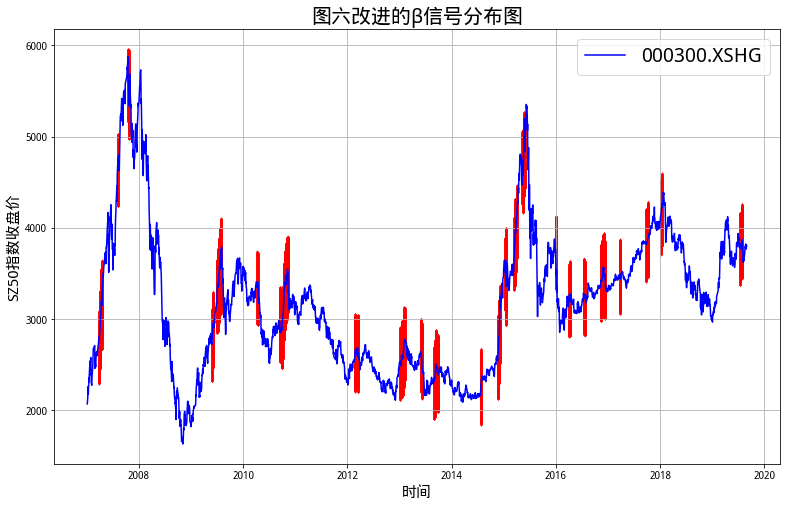

In [13]:
###单侧置信区间下限为百分之10，并增加过滤指标时belta信号的分布状况
signal_03 = pd.DataFrame([])
for i in range(len(x1_negative)):
    if x1_negative[name][i]<x1_negative['quantile-0.1'][i   ###筛选出小于单侧置信区间10%下限的值###
    ] and x1_negative.MA30[i]>x1_negative.MA30[i-30         ###筛选出大于前30天MA30的值###
    ] and x1_negative.R_MA22[i]>0:                          ###筛选出22天平均收益率大于0的值###
        eden =  pd.DataFrame(x1_negative.iloc[i,:]).T                                                                                                
        signal_03 = signal_03.append(eden)
        
        
###改良后的信号坐标###
Y = R_300.loc[signal_03.index].low
X = signal_03.index

print('单侧置信区间下限为百分之10并改进后的belta信号总共出现了%s次'%len(signal_03))
print('')


fig = plt.subplots(figsize=(13,8))
plt.plot(R_300.close,'b',label='A000300.XSHG')   
plt.grid(True)
plt.title('图六改进的β信号分布图',fontsize=20)
plt.legend(['000300.XSHG'],fontsize=20)


for x in X:
    loc = int(Y.loc[x])
    c = range(loc-400,loc+400)
    plt.scatter([x]*len(c),c,color='r',marker='.',s=1)
    
plt.xlabel('时间',fontsize=15)
plt.ylabel('SZ50指数收盘价',fontsize=15)
plt.show()

    到这里本文发现在运用均线过滤异常情况后，可以直观地看出已经过滤掉了大部分下跌市场时的信号，提高了策略的成功率和收益率。信号量缩小到195次，且信号的纯度更高。
    

### 展示多空的因子信号分布状况

本文基于原有研报的基础上进行改良。研报显示市场存在下跌趋势时，羊群效应策略效果相对不显著的原因可能是卖空限制导致投资者可抛售的股票数量有限，因此下跌时羊群效应发生后下跌趋势持续时间较短。于此，本文对做空信号的因子过滤的均线选择为短期均线MA5.

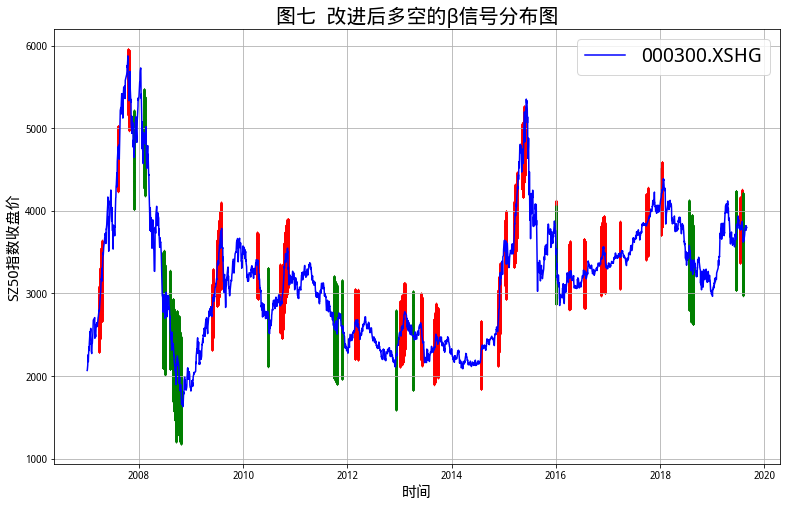

In [14]:
###基于上文改良，belta信号的多空分布状况
long_signal = pd.DataFrame([])
for i in range(len(x1_negative)):
    if x1_negative[name][i]<x1_negative['quantile-0.1'][i ###筛选出小于单侧置信区间10%下限所在值###                
        ] and x1_negative.MA30[i]>x1_negative.MA30[i-30   ###筛选出大于前30天MA30的值###
        ] and x1_negative.R_MA22[i]>0:                    ###筛选出22天平均收益率大于0的值###
        
        long =  pd.DataFrame(x1_negative.iloc[i,:]).T                                                                                                
        long_signal = long_signal.append(long)
        
        
short_signal = pd.DataFrame([])
for i in range(len(x1_negative)):
    
    if x1_negative[name][i]<x1_negative['quantile-0.1'][i ###筛选出小于单侧置信区间10%下限所在值###             
        ] and x1_negative.MA30[i]<x1_negative.MA30[i-5    ###筛选出大于前 5天MA30的值###
        ] and x1_negative.R_MA22[i]<0:                    ###筛选出22天平均收益率小于0的值###
        
        short =  pd.DataFrame(x1_negative.iloc[i,:]).T                                                                                                
        short_signal = short_signal.append(short)
      
    
###做多的信号坐标###
Y_long = R_300.loc[long_signal.index].low
X_long = long_signal.index
###做空的信号坐标###
Y_short = R_300.loc[short_signal.index].low
X_short = short_signal.index


fig = plt.subplots(figsize=(13,8))
plt.plot(R_300.close,'b',label='000300.XSHG')
plt.title('图七  改进后多空的β信号分布图',fontsize=20)
plt.grid(True)


for long in X_long:
    loc = int(Y_long.loc[long])
    c = range(loc-400,loc+400)
    plt.scatter([long]*len(c),c,color='r',marker='.',s=1)
    
for short in X_short:
    loc = int(Y_short.loc[short])
    c = range(loc-600,loc+600)
    plt.scatter([short]*len(c),c,color='green',marker='.',s=1)
    
plt.legend(['000300.XSHG'],fontsize=20)
plt.xlabel('时间',fontsize=15)
plt.ylabel('SZ50指数收盘价',fontsize=15)
plt.show()

从上图中可以很明显的看出，做空信号的发生除了在08年崩盘的之外，其他时候基本都发生在下跌时某个阶段的末段，这与研报的分析的相同，在下跌时羊群效应发生后下跌趋势持续时间较短。

(代码的打包操作放于回测部分)

# 策略思路以及策略回测

        选择投资者较为熟悉的六种宽基指数，上证综指、上证50、沪深300、中证500、中小板综合指数、创业板指数
        策略标的：以上六种宽基指数
        股票组合：当日标的指数的成分股，剔除ST股等非正常交易状态股票        
        回测时间：2017年1月1日至2019年9月1日        
        手续费用：在此回测暂时忽略，但在回测引擎上设置为双边千三 
        
        策略步骤：（做多）
                     向前22日计算每天（包括当天）的成份股组合截面绝对离散度CSAD，OLS估计CCK模型中Rm平方的系数β2。
                     向前计算180天内的样本单侧置信区间10%下限。
                     向前计算22日内标的指数平均收益率的正负区间，运用正负判断市场趋势
                     向前计算MA30
                 开仓：当β2小于单侧置信区间下限，标的指数平均收益率为正，当日MA30大于30天前的MA30时，买入标的指数。
                 清仓：持有22天后卖出。（为了接近研报，暂时不加入止损止盈，但是之后会在评论区发布）
                 -----------------------------------------------------------------------------------------------------
                  （做空）
                     所需计算的指标同上文做多策略。
                 开仓：当β2小于单侧置信区间下限，标的指数平均收益率为正，当日MA30小于5天前的MA30时，买入标的指数。
                 清仓：持有7天后卖出。（为了接近研报，暂时不加入止损止盈，但是之后会在评论区发布）

## 羊群效应策略在宽基指数上的应用

In [149]:
def get_signal(industry_code,direction,interval_time):
    """简述get_signal的参数和返回值：
参数： industry = 标的指数的列表，列表可以包含多个标的或单个标的指数，但是industry的格式必须是列表。
      direction = 仅能输入‘buy’和 ‘sell’    interval_time = 同上文的一样，是个时间间隔的列表。
返回值：signal_group = 返回一个dict，里面包含每个标的指数在interval_time的时间内出现的所有信号。
                        返回的dict的一级字典键为标的指数的代码，每个键对应值的格式为dataframe。
    """
    industry = industry_code
    time = interval_time
    
    all_belta = pd.DataFrame([])
    for i in industry:
        blanket_stocks = get_stocks_interval(i,time)
        stocks_section = get_stocks_section(blanket_stocks,time)
        belta  = get_stocks_belta(stocks_section,time)    ###获取每个指数的每天的belta信号###
        all_belta[i] = belta.x1                           ###存入all_belta这dataframe里面###
        
        
    signal_group={} 
    if direction == 'buy':
        for k in industry:
            signal = pd.DataFrame([])
            frame = get_analysis_frame(k,all_belta[k],time)    
            for i in range(len(frame)):
                if frame[k][i]<frame['quantile-0.1'][i    ###筛选出小于单侧置信区间10%下限所在值###
                    ] and frame.MA30[i]>frame.MA30[i-30   ###筛选出大于前30天MA30的值###
                    ] and frame.R_MA22[i]>0:              ###筛选出22天平均收益率大于0的值###

                    long =  pd.DataFrame(frame.iloc[i,:]).T                                                                        
                    signal = signal.append(long)
            signal_group[k] = signal   ###将每个指数出现的做多信号以dict形式存储起来###
            
    elif direction =='sell':
        for k in industry:
            signal = pd.DataFrame([])
            frame = get_analysis_frame(k,all_belta[k],time)
            for i in range(len(frame)):
                if frame[k][i]<frame['quantile-0.1'][i    ###筛选出小于单侧置信区间10%下限所在值###
                    ] and frame.MA30[i]<frame.MA30[i-5    ###筛选出大于前5天MA30的值###
                    ] and frame.R_MA22[i]<0:              ###筛选出22天平均收益率大于0的值###

                    short =  pd.DataFrame(frame.iloc[i,:]).T                                                                                                
                    signal = signal.append(short)
            signal_group[k] = signal   ###将每个指数出现的做空信号以dict形式存储起来###
            
    return signal_group

In [150]:
"""简述get_back_analysis_data（）函数的参数和返回值

参数：daliy_rate = 每日的收益率，格式必须是一列dataframe     code = 回测的标的的代码，最好只是一个字符串。
      cum_rate = 每日收益率的累加，格式也是必须一列dataframe
      days = 回测的天数（日历日，非工作日。因为计算年化要用日历日）
返回值： 一个1×1的dataframe，包含标的的最终收益率，年化收益率，最大回撤，夏普比率
"""

def get_back_analysis_data(daliy_rate,cum_rate,code,days):
    rate = cum_rate
    Daliy_rate = np.array(daliy_rate)
    
    ###计算最大回撤###
    re = []
    for k in range(len(rate)):
        retreat = max(rate.iloc[k,0]-rate.iloc[k:,0])
        re.append(retreat)
    max_retreat = max(re)  
    
    ###计算收益率###
    earn = rate.iloc[-1,-1]-1 
    
    ###计算年化收益率###
    annual_return = (earn)*365/days      
    
    ###计算夏普比率###
    ex_pct_close = Daliy_rate - 0.04/252
    sharpe = (ex_pct_close.mean() * math.sqrt(252)
                     )/ex_pct_close.std()
    
    analysis_datas = [earn,annual_return,max_retreat,sharpe]
    back_analysis_data = pd.DataFrame(analysis_datas,
                                      index =['收益率','年化收益率','最大回撤','夏普比率'
                                      ],columns = [code]).T
    
    return  back_analysis_data

In [151]:
def get_backtest_gain(code_list,direction,interval_time):   
    """参数：code_list = 同get_analysis_frame函数一样，必须是个包含标的指数字符串代码的列表，数量不限。
          direction = 同get_signal函数一样，必须是‘buy’或者‘sell’        
          interval_time = 同上文
       返回值：gain_dict = 字典，包含code_list里面每个标的指数在interval_time内每天的收益率
           back_revenue = 一个dataframe，包含每个code_list回测的数据分析，收益、年化、回撤、夏普
    """

    to = time.time()
    signal_group = get_signal(code_list,direction,interval_time)
    color = ['red','orange','yellow','green','blue','purple']
    back_revenue = pd.DataFrame()       ###用于存放每个标的的回测收益数据###
    start = interval_time[0]
    end = interval_time[-1]


    gain_dict={}
    keys = list(signal_group.keys())
    for i in range(len(keys)):
        stock = keys[i]
        
        ###判断是行业指数还是宽基指数###
        if len(stock)==11:
            index = get_price(stock,start_date=start,end_date=end,fields='close')
            back_data = index.pct_change(1)

        elif len(stock)==6:
            q = finance.run_query(query(finance.SW1_DAILY_PRICE
                                          ).filter(finance.SW1_DAILY_PRICE.code==stock,
                                                   finance.SW1_DAILY_PRICE.date > start,
                                                   finance.SW1_DAILY_PRICE.date < end))
            
            change_index_format = get_price('000001.XSHG',start_date=start,
                                                          end_date=end,fields='close')
            
            industry = pd.DataFrame(list(q.close),
                                    index=change_index_format.index,
                                    columns=['close'])
            back_data = industry.pct_change(1)
  

        ###取出信号出现的日期索引###
        signal_time = signal_group[stock].index
        ###创建一个NaN列表，在对应行存入对应的收益率，再向前填充NaN##
        backtest = [NaN]*len(back_data.index)     
        

        
        for j in signal_time:
            
            ###信号所在行数###
            row = int(np.where(back_data.index == j)[0])
            ###避免未来函数，信号出现的第二天才开始计算收益率###
            if direction=='buy':
                backtest[row+1:row+23] = back_data.iloc[row+1:row+23].close
            elif direction=='sell':
                backtest[row+1:row+8] = back_data.iloc[row+1:row+8].close*-1
                
                
        backtest = pd.DataFrame(backtest,index=back_data.index,columns=['b_s'])
        backtest = backtest.fillna(0)
        R_backtest=backtest
        gain_dict[keys[i]] = R_backtest

            
        """生成回测数据"""
        ###回测数据预处理###
        R_backtest.iloc[0,0]=1    ###累积收益计算完成后第一个值再变回零###
        R_cum = R_backtest.cumsum()
        R_backtest.iloc[0,0]=0    ###第一个值再变回零是为了谨慎计算sharpe
                                  ###不然计算时会把第一天的收益当成100%去计算###
        
        days = len(pd.date_range(start,end))   ###计算interval_time列表中首末日期相隔的日历日###
        revenue = get_back_analysis_data(R_backtest,R_cum,keys[i],days)
        back_revenue = back_revenue.append(revenue)    ###把标的的回测收益数据存入back_revenue###
    
    
    return gain_dict,back_revenue


In [126]:
index_code = ['000001.XSHG','000016.XSHG','000300.XSHG'
              ,'000905.XSHG','399101.XSHE','399006.XSHE']
interval_time = ['2007-01-01','2008-01-01','2009-01-01','2010-01-01'
                ,'2011-01-01','2012-01-01','2013-01-01','2014-01-01'
                ,'2015-01-01','2016-01-01','2017-01-01','2018-01-01'
                ,'2019-01-01','2019-09-01']

宽基指数做多净值组合回测数据表格


,收益率,年化收益率,最大回撤,夏普比率
000001.XSHG,0.346744,0.027353,0.428764,-0.100638
000016.XSHG,0.733067,0.057828,0.432118,0.143298
000300.XSHG,0.595125,0.046946,0.499953,0.062478
000905.XSHG,0.206184,0.016265,0.365220,-0.190114
399101.XSHE,0.167242,0.013193,0.325257,-0.209531
399006.XSHE,0.256654,0.020246,0.503024,-0.150674


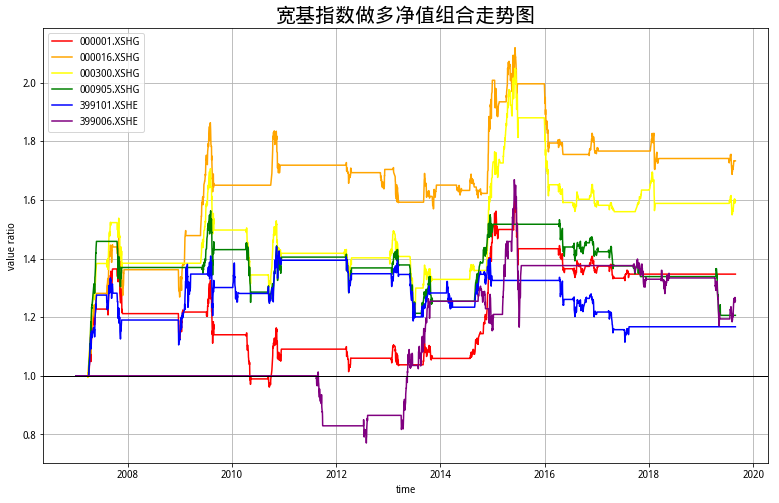

宽基指数做空净值组合回测数据表格


,收益率,年化收益率,最大回撤,夏普比率
000001.XSHG,0.172045,0.013572,0.258997,-0.267814
000016.XSHG,0.037193,0.002934,0.401545,-0.402729
000300.XSHG,0.405540,0.031991,0.176070,-0.072525
000905.XSHG,0.387815,0.030593,0.241762,-0.078251
399101.XSHE,0.020532,0.001620,0.483918,-0.361633
399006.XSHE,-0.400001,-0.031554,0.433998,-0.811263


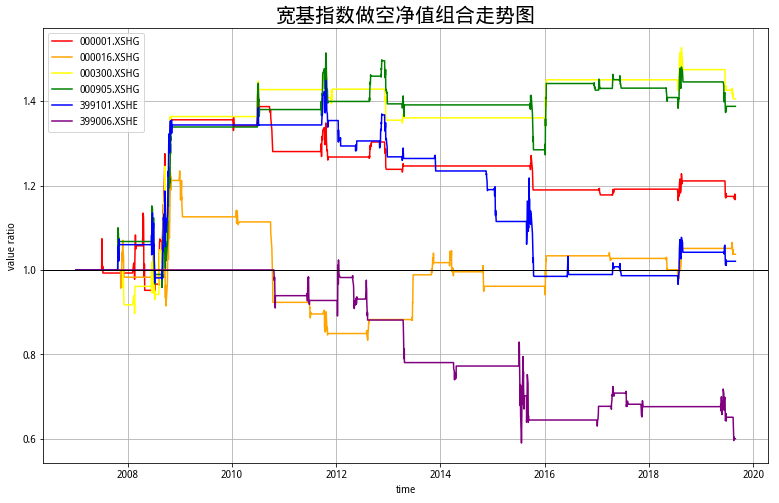

回测完成 总耗时 531.554 秒



In [25]:
###宽基指数多空回测###
t0 = time.time()

long_back_rate,long_back_revenue = get_backtest_gain(index_code,'buy',interval_time)
short_back_rate,short_back_revenue = get_backtest_gain(index_code,'sell',interval_time)

back_rate = [long_back_rate,short_back_rate]
back_revenue = [long_back_revenue,short_back_revenue]

index_colors = ['red','orange','yellow','green','blue','purple']

for k in range(0,2):
    
    fig=plt.figure(figsize=(13,8))
    ax1=fig.add_subplot(1,1,1)

    keys = list(back_rate[k].keys())
    for i in range(len(keys)):
        target = keys[i]
        target_back_rate = back_rate[k][target]
        target_back_rate.iloc[0,0]=1
        target_back_rate_cum = target_back_rate.cumsum()
        
        ax1.plot(target_back_rate_cum,index_colors[i])

    plt.grid(True)
    plt.xlabel('time')
    plt.ylabel('value ratio') 
    #ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    ax1.axhline(1.0, linestyle='-', color='black', lw=1)
    plt.legend(index_code,loc=2,fontsize=10) 

    if k == 0:
        print('宽基指数做多净值组合回测数据表格')
        plt.title('宽基指数做多净值组合走势图',fontsize=20) 
        
    elif k ==1 :
        print('宽基指数做空净值组合回测数据表格')
        plt.title('宽基指数做空净值组合走势图',fontsize=20) 
    display(back_revenue[k])
    print('')
    plt.show()
    
    
t1 = time.time()   
print('回测完成 总耗时 %s 秒' %round((t1-t0),3))  
print('')    


    做多策略时，策略在宽基指数上的平均表现为上图，可以看出在每轮牛市时，羊群效应策略效果相对较为显著，在沪深300和上证50等高市值指数回测结果优于低市值指数。标的为上证50时，收益率达到73.3%，年化5.7%，最大回撤略大43.2%，夏普0.14。
    总的来说，上证50，沪深300的表现均优于中证500，中小板综，创业板指，上证综指。
    
    做空策略时，策略在宽基指数上的表现一般，表现最好最明显的是沪深300，收益率达到40.5%。但是回测结果最差的却是创业板指数，亏损40%。
    在所有策略中，尽管加入过过滤指标改良，但是还是不可避免的出现羊群效应发生时错误的市场判断。

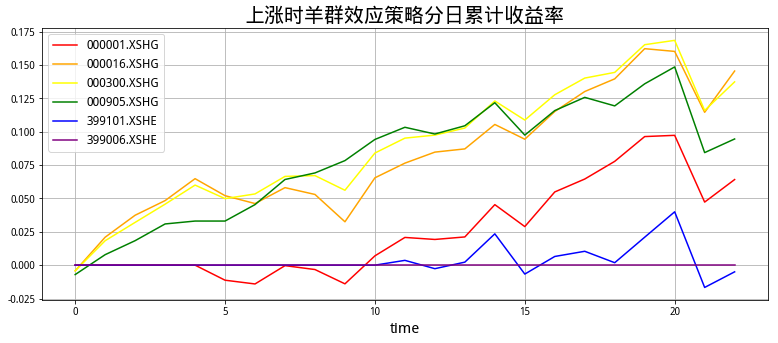

In [53]:
###上涨时羊群效应策略分日累计收益率
fig=plt.figure(figsize=(13,5))
ax2=fig.add_subplot(1,1,1)
long_keys = list(long_back_rate.keys())

for i in range(len(long_keys)):
    sample = long_back_rate[keys[i]].loc['2009-06-30':'2009-07-30']
    sample = sample.reset_index(drop=True)
    cum_sample = sample.cumsum()
    ax2.plot(cum_sample,index_colors[i])
    
plt.title('上涨时羊群效应策略分日累计收益率',fontsize=20)
plt.grid(True)
plt.xlabel('time',fontsize=15)
plt.legend(long_keys,fontsize=12)
plt.show()

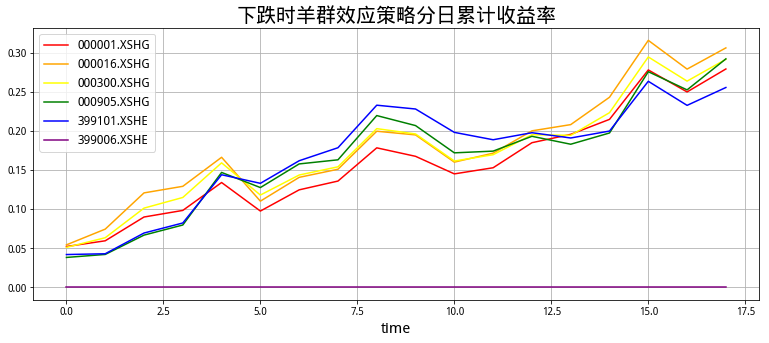

In [54]:
###下跌时羊群效应策略分日累计收益率
fig=plt.figure(figsize=(13,5))
ax2=fig.add_subplot(1,1,1) 
short_keys = list(short_back_rate.keys())

for i in range(len(short_keys)):
    sample = short_back_rate[keys[i]].loc['2008-09-30':'2008-10-29']
    sample = sample.reset_index(drop=True)
    cum_sample = sample.cumsum()
    ax2.plot(cum_sample,index_colors[i])
    
plt.title('下跌时羊群效应策略分日累计收益率',fontsize=20)
plt.grid(True)
plt.xlabel('time',fontsize=15)
plt.legend(short_keys,fontsize=12)
plt.show()

## 羊群效应策略在行业指数上的应用

        申万一级行业指数，并分成4大类，金融型，成长型，消费型，周期型
        策略标的：以上4大类行业
        股票组合：当日标的指数的成分股，剔除ST股等非正常交易状态股票        
        回测时间：2014年3月1日至2019年9月1日        
        手续费用：在此回测暂时忽略，但在回测引擎上设置为双边千三 
        
        策略步骤：（做多）
                     向前22日计算每天（包括当天）的成份股组合截面绝对离散度CSAD，OLS估计CCK模型中Rm平方的系数β2。
                     向前计算180天内的样本单侧置信区间10%下限。
                     向前计算22日内标的指数平均收益率的正负区间，运用正负判断市场趋势
                     向前计算MA30
                 开仓：当β2小于单侧置信区间下限，标的指数平均收益率为正，当日MA30大于30天前的MA30时，做多标的指数。
                 清仓：持有22天后卖出。（为了接近研报，暂时不加入止损止盈，但是之后会在评论区发布）
                 -----------------------------------------------------------------------------------------------------
                  （做空）
                     所需计算的指标同上文做多策略。
                 开仓：当β2小于单侧置信区间下限，标的指数平均收益率为负，当日MA30小于5天前的MA30时，做空标的指数。
                 清仓：持有7天后卖出。（为了接近研报，暂时不加入止损止盈，但是之后会在评论区发布）

In [76]:
Cycle = ['801020','801030','801040','801050','801710',
         '801720','801730','801890','801170','801180','801160']

Consumption = ['801180','801110','801130','801200',
               '801120','801150','801210','801140','801010']

Growth = ['801080','801770','801760','801750','801740']

Finance = ['801780','801790']

times  = ['2014-03-01','2015-01-01','2016-01-01','2017-01-01'
          ,'2018-01-01','2019-01-01','2019-09-01']

在进行股票获取的时候发现，聚宽申万一级提供的行业成份股中，金融型【‘801780’，‘801790’】,还有电子，传媒等行业在14年2月10日之前是没有成份股的，

所以在行业指数上的回测时间从14年3月1日至19年9月1日

In [77]:
###获取四大类内每个行业回测的没日收益率和回测分析表格

t0=time.time()
Cycle_long_back_rate,Cycle_long_back_revenue = get_backtest_gain(Cycle,'buy',times)
Cycle_short_back_rate,Cycle_short_back_revenue = get_backtest_gain(Cycle,'sell',times)

Growth_long_back_rate,Growth_long_back_revenue = get_backtest_gain(Growth,'buy',times)
Growth_short_back_rate,Growth_short_back_revenue = get_backtest_gain(Growth,'sell',times)


Consumption_long_back_rate,Consumption_long_back_revenue = get_backtest_gain(Consumption,'buy',times)
Consumption_short_back_rate,Consumption_short_back_revenue = get_backtest_gain(Consumption,'sell',times)


Finance_long_back_rate,Finance_long_back_revenue = get_backtest_gain(Finance,'buy',times)
Finance_short_back_rate,Finance_short_back_revenue = get_backtest_gain(Finance,'sell',times)

t1=time.time()
print('获取回测数据完毕 总耗时 %s 秒' %round((t1-t0),3))  
print('')   
print('buy:周期型各行业回测数据表格')
display(Cycle_long_back_revenue)
print('')   
print('buy:消费型各行业回测数据表格')
display(Growth_long_back_revenue)
print('')   
print('buy:成长型各行业回测数据表格')
display(Consumption_long_back_revenue)
print('')   
print('buy:金融型各行业回测数据表格')
display(Finance_long_back_revenue)

获取回测数据完毕 总耗时 587.899 秒

buy:周期型各行业回测数据表格


,收益率,年化收益率,最大回撤,夏普比率
801020,0.037926,0.006884,0.162903,-0.310792
801030,-0.025909,-0.004702,0.386306,-0.397694
801040,0.476143,0.086421,0.181932,0.433054
801050,0.157215,0.028535,0.317211,-0.102299
801710,0.166769,0.030269,0.459767,-0.068450
801720,0.626404,0.113693,0.415690,0.474437
801730,-0.010821,-0.001964,0.263858,-0.483706
801890,0.050672,0.009197,0.543592,-0.249179
801170,0.195391,0.035464,0.146443,-0.041852
801180,0.005584,0.001014,0.453538,-0.345601



buy:消费型各行业回测数据表格


,收益率,年化收益率,最大回撤,夏普比率
801080,-0.435318,-0.079011,0.663606,-0.759649
801770,0.297343,0.053968,0.224392,0.125091
801760,-0.447098,-0.081149,0.656559,-0.977842
801750,0.189583,0.034410,0.460755,-0.033773
801740,0.430927,0.078214,0.527524,0.213512



buy:成长型各行业回测数据表格


,收益率,年化收益率,最大回撤,夏普比率
801180,0.005584,0.001014,0.453538,-0.345601
801110,0.199715,0.036249,0.192249,-0.020583
801130,-0.012171,-0.002209,0.274304,-0.506434
801200,-0.059810,-0.010856,0.476102,-0.451577
801120,0.209936,0.038104,0.298786,-0.005005
801150,-0.036349,-0.006597,0.157973,-0.680266
801210,-0.154635,-0.028066,0.514096,-0.577282
801140,0.243703,0.044232,0.141634,0.091739
801010,-0.254321,-0.046160,0.629633,-0.596834



buy:金融型各行业回测数据表格


,收益率,年化收益率,最大回撤,夏普比率
801780,-0.052537,-0.009536,0.485530,-0.388056
801790,0.495566,0.089946,0.549961,0.277082


    由于数据过多，不方便一起展示，所以上面四个表格只显示了四大类行业每个行业做多的收益分析表格，没有显示做空的。
    在回测中，周期型行业的801720-建筑装饰行业和801040-钢铁行业的做多盈利达到62%和47%，高于周期型的其他行业。
             消费型行业的801740-通信行业的做多盈利达到43%，在消费型行业中较为突出，是其中唯一一个收益率为正的行业。
             成长型行业的801140-轻工制造行业的做多盈利达到24.3%。
             金融型行业的801790-非银行金融行业的做多盈利达到49.5%。
             在所有行业中表现最差的是消费型行业中801760-传媒行业和801080-电子行业，做多亏损率分别为-44.7%和-43%。
             

In [78]:
###通过每个行业的收益率计算四大类的平均收益率

industry_long_list = [Cycle_long_back_rate,Growth_long_back_rate
                      ,Consumption_long_back_rate,Finance_long_back_rate]

industry_short_list = [Cycle_short_back_rate,Growth_short_back_rate
                      ,Consumption_short_back_rate,Finance_short_back_rate]

for industry in industry_long_list:
    keys=list(industry.keys())
    industry['avg_rate'] = industry[keys[0]]
    for i in range(len(keys)-1):
        industry['avg_rate'] += industry[keys[i+1]] ###累加计算出每个大类做多的总的收益率
                                                    ###并在下文代码除以每个大类的行业数求得平均收益率
        
for industry in industry_short_list:
    keys=list(industry.keys())
    industry['avg_rate'] = industry[keys[0]]
    for i in range(len(keys)-1):
        industry['avg_rate'] += industry[keys[i+1]] ###累加计算出每个大类做多的总的收益率
                                                    ###并在下文代码除以每个大类的行业数求得平均收益率
            

Cycle_avg_long_rate = Cycle_long_back_rate['avg_rate']/11
Consumption_avg_long_rate = Consumption_long_back_rate['avg_rate']/5
Growth_avg_long_rate = Growth_long_back_rate['avg_rate']/9
Finance_avg_long_rate = Finance_long_back_rate['avg_rate']/2


四大类行业指数回测数据分析表格


,收益率,年化收益率,最大回撤,夏普比率
Cycle,0.159254,0.028905,0.247350,-0.133496
Consumption,0.028330,0.005142,0.467055,-0.261424
Growth,0.003937,0.000715,0.238358,-0.668747
Finance,0.221514,0.040205,0.447265,0.010302


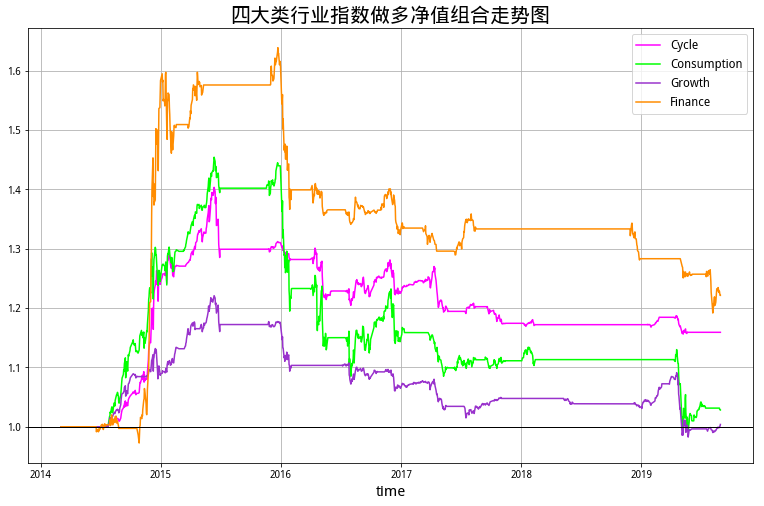

In [80]:
###四大类行业做多回测累计收益率###
industry_colors = ['magenta','lime','darkorchid','darkorange']

industry_avg_long_list = [Cycle_avg_long_rate,Consumption_avg_long_rate
                          ,Growth_avg_long_rate,Finance_avg_long_rate]

classfiy_name = ['Cycle','Consumption','Growth','Finance']
industry_long_data = pd.DataFrame()

for avg in range(0,4):
    analysis = get_back_analysis_data(industry_avg_long_list[avg]
                                      ,industry_avg_long_list[avg].cumsum()+1
                                      ,classfiy_name[avg],2011)
                                        ###行业指数回测总日历天数为2011天
    industry_long_data = industry_long_data.append(analysis)
    
print('四大类行业指数回测数据分析表格')
display(industry_long_data)


fig=plt.figure(figsize=(13,8))
ax3=fig.add_subplot(1,1,1)   
for avg in range(0,4):
    ax3.plot(industry_avg_long_list[avg].cumsum()+1,industry_colors[avg])
plt.title('四大类行业指数做多净值组合走势图',fontsize=20)
plt.grid(True)
ax3.axhline(1.0, linestyle='-', color='black', lw=1)
plt.xlabel('time',fontsize=15)
plt.legend(classfiy_name,fontsize=12)
plt.show()

    在做多策略中，羊群效应策略效果不能说太好，但是有一个缺点就所有行业指数的收益大部分来自大牛市之中
    在大牛市过后的市场震荡阶段策略表现明显欠佳。
    表现最好的是市值较大的金融型行业，在大牛市中行业指数涨幅较大，收益较高，但是在之后的震荡市之中错误分辨信号导致亏损。

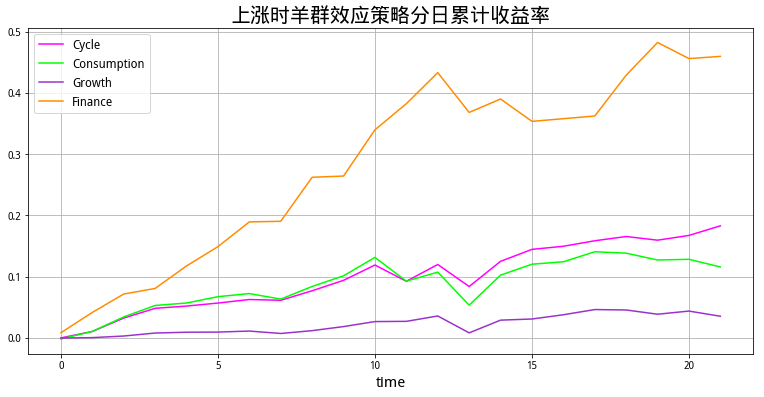

In [81]:
###行业指数上涨时羊群效应策略分日累计收益率
fig=plt.figure(figsize=(13,6))
ax4=fig.add_subplot(1,1,1)  

for i in range(len(industry_avg_long_list)):
    sample = industry_avg_long_list[i].loc['2014-11-20':'2014-12-21']
    sample = sample.reset_index(drop=True)
    cum_sample = sample.cumsum()
    ax4.plot(cum_sample,industry_colors[i])
plt.title('上涨时羊群效应策略分日累计收益率',fontsize=20)
plt.grid(True)
plt.xlabel('time',fontsize=15)
plt.legend(classfiy_name,fontsize=12)
plt.show()

    下跌时羊群效应的分日累计本文选取2014年11月20到12月21日，期间市场是处于大牛市阶段，市场出现较大的涨幅。
    该阶段表现最好的是金融型行业，最差的是成长型行业。

四大类行业指数回测数据分析表格


,收益率,年化收益率,最大回撤,夏普比率
Cycle,-0.084052,-0.015256,0.106787,-1.650087
Consumption,-0.134513,-0.024414,0.269583,-0.718147
Growth,-0.055831,-0.010133,0.092003,-1.202298
Finance,0.011144,0.002023,0.078327,-1.173918


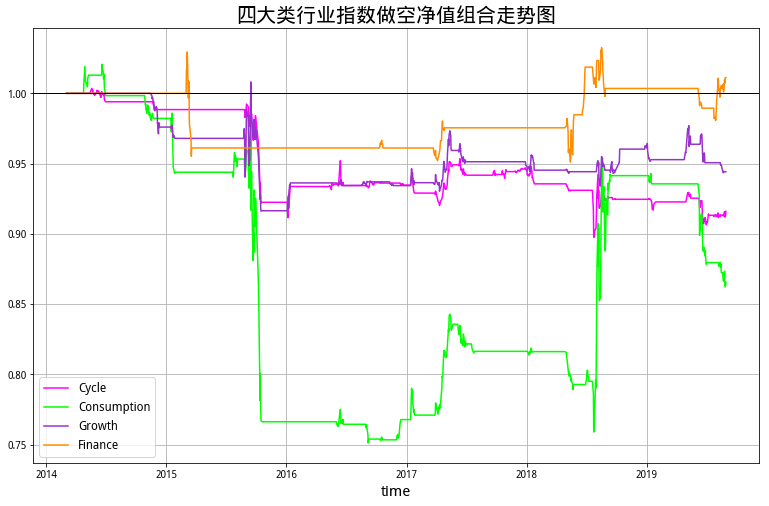

In [82]:
###四大类行业做空回测累计收益率###
Cycle_avg_short_rate = Cycle_short_back_rate['avg_rate']/11
Consumption_avg_short_rate = Consumption_short_back_rate['avg_rate']/5
Growth_avg_short_rate = Growth_short_back_rate['avg_rate']/9
Finance_avg_short_rate = Finance_short_back_rate['avg_rate']/2

industry_avg_short_list = [Cycle_avg_short_rate,Consumption_avg_short_rate
                          ,Growth_avg_short_rate,Finance_avg_short_rate]

industry_short_data = pd.DataFrame()

for avg in range(0,4):
    analysis = get_back_analysis_data(industry_avg_short_list[avg]
                                      ,industry_avg_short_list[avg].cumsum()+1
                                      ,classfiy_name[avg],2011)
    industry_short_data = industry_short_data.append(analysis)
    
print('四大类行业指数回测数据分析表格')
display(industry_short_data)


fig=plt.figure(figsize=(13,8))
ax3=fig.add_subplot(1,1,1)   
for avg in range(0,4):
    ax3.plot(industry_avg_short_list[avg].cumsum()+1,industry_colors[avg])
plt.title('四大类行业指数做空净值组合走势图',fontsize=20)
plt.grid(True)
ax3.axhline(1.0, linestyle='-', color='black', lw=1)
plt.xlabel('time',fontsize=15)
plt.legend(classfiy_name,fontsize=12)
plt.show()

    在做空策略中，即使把策略清仓时间缩短到7天，羊群效应策略在行业指数上的效果也是相对不显著。
    总收益率方面，所以行业均为负收益。
    大部分亏损发生于15年下半年后，当时市场处于牛市变熊市阶段且触摸到阶段性底部。
    由于此时波动较大，发出了错误方向信号，导致亏损。

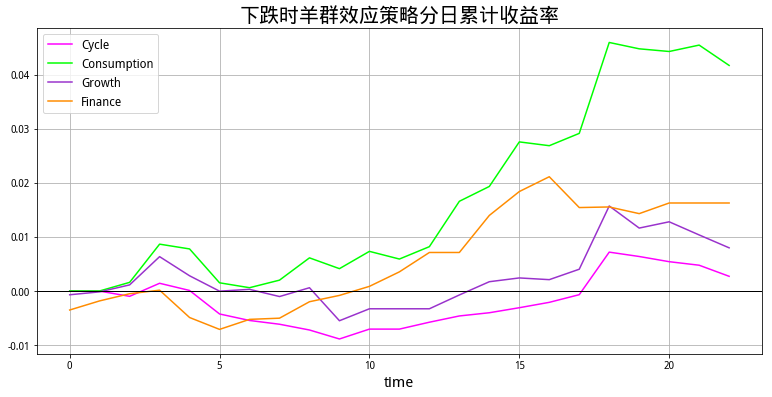

In [83]:
###行业指数下跌时羊群效应策略分日累计收益率
fig=plt.figure(figsize=(13,6))
ax5=fig.add_subplot(1,1,1)  

for i in range(len(industry_avg_short_list)):
    sample = industry_avg_short_list[i].loc['2017-03-25':'2017-04-29']
    sample = sample.reset_index(drop=True)
    cum_sample = sample.cumsum()
    ax5.plot(cum_sample,industry_colors[i])
plt.title('下跌时羊群效应策略分日累计收益率',fontsize=20)
plt.grid(True)
plt.xlabel('time',fontsize=15)
plt.legend(classfiy_name,fontsize=12)
ax5.axhline(0, linestyle='-', color='black', lw=1)
plt.show()

     下跌时羊群效应的分日累计本文选取2014年3月25到4月29日，期间市场是处于慢牛回调阶段，市场出现较大的跌幅。
     该阶段表现最好的消费性行业，最差的是金融型行业。

# 结论
## 1.标的指数的市值越高，策略效果越明显
## 2.通过研报和本文分析，羊群效应确实存在，但是重要的是市场方向的区分，而本文虽有在这方面进行改进，但还是会出现错误的判断。所以羊群效应要想有好的表现就必须要正确区分信号所代表的市场方向。
## 3.单从本文的回测结果看，该策略明显不足，收益率低，回撤大，且大部分策略收益都在大牛市，在震荡期间策略表现不明显，所以策略还不成熟，有待改进